In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
# tf.disable_eager_execution()

In [2]:
import pandas as pd
import numpy as np
import random as random
import pyarrow as pa 
import pyarrow.parquet as pq
from fastavro import writer, reader, parse_schema
import collections

In [3]:
from tensorflow.python.keras.optimizers import Adam, SGD

In [4]:
import sonnet as snt

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
records = []
with open('okex_spot_ETH_BTC_60.avro', 'rb') as fo:
    for record in reader(fo):
        records.append(record)

In [7]:
data = pd.DataFrame(records)

In [8]:
df = data.copy()

In [9]:
df = (df.sort_values(by=['window_end']).set_index(['window_end'])[150:]).fillna(method="ffill")

In [10]:
df.head()

,all_close_price,all_close_quantity,all_count,all_high_price,all_high_quantity,all_low_price,all_low_quantity,all_mean_price,all_mean_quantity,all_open_price,...,sell_low_price,sell_low_quantity,sell_mean_price,sell_mean_quantity,sell_open_price,sell_open_quantity,sell_std_price,sell_std_quantity,sell_volume,sell_vwap
window_end,,,,,,,,,,,,,,,,,,,,,
1557016019999,0.02825,0.003355,17.0,0.02828,0.056520,0.02825,0.000058,0.028262,0.021548,0.02827,...,0.02825,0.000058,0.028262,0.021548,0.02827,0.000144,0.000010,0.024675,0.366322,0.028261
1557016049999,0.02824,0.003365,23.0,0.02826,0.293876,0.02823,0.000132,0.028243,0.050195,0.02825,...,0.02823,0.000132,0.028243,0.050195,0.02825,0.035443,0.000008,0.070967,1.154495,0.028245
1557016079999,0.02824,0.018901,93.0,0.02825,0.719105,0.02822,0.000934,0.028234,0.051819,0.02824,...,0.02822,0.000934,0.028234,0.051819,0.02824,0.007907,0.000010,0.106241,4.819172,0.028235
1557016109999,0.02824,0.007759,6.0,0.02824,0.372039,0.02824,0.000070,0.028240,0.126429,0.02824,...,0.02824,0.000070,0.028240,0.126429,0.02824,0.002850,0.000000,0.190265,0.758575,0.028240
1557016139999,0.02823,0.411671,14.0,0.02823,0.492622,0.02822,0.000562,0.028229,0.146739,0.02823,...,0.02822,0.000562,0.028229,0.146739,0.02823,0.056460,0.000003,0.173626,2.054350,0.028230


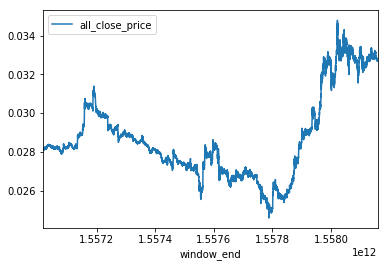

In [11]:
window_size=90
features = [
    'all_close_price', 
    'all_high_price', 
    'all_mean_price', 
    'all_low_price',
    'sell_close_price', 
    'sell_high_price', 
    'sell_mean_price', 
    'sell_low_price',
    'buy_close_price', 
    'buy_high_price', 
    'buy_mean_price', 
    'buy_low_price',
    'ask_0_close_price', 
    'ask_0_high_price', 
    'ask_0_mean_price', 
    'ask_0_low_price',
    'bid_0_close_price', 
    'bid_0_high_price', 
    'bid_0_mean_price', 
    'bid_0_low_price',
    'ask_1_close_price', 
    'ask_1_high_price', 
    'ask_1_mean_price', 
    'ask_1_low_price',
    'bid_1_close_price', 
    'bid_1_high_price', 
    'bid_1_mean_price', 
    'bid_1_low_price',
    'ask_2_close_price', 
    'ask_2_high_price', 
    'ask_2_mean_price', 
    'ask_2_low_price',
    'bid_2_close_price', 
    'bid_2_high_price', 
    'bid_2_mean_price', 
    'bid_2_low_price',
    'ask_3_close_price', 
    'ask_3_high_price', 
    'ask_3_mean_price', 
    'ask_3_low_price',
    'bid_3_close_price', 
    'bid_3_high_price', 
    'bid_3_mean_price', 
    'bid_3_low_price'    
]
batch_num = len(df) - 92
max_leverage = 5
learning_rate=0.00028

In [18]:
Batch = collections.namedtuple(
    'Batch',
    [
        'frames',
        'next_prices',
        'current_prices',
        'decay',
        'commission',
        'max_leverage',
        'size'
    ]
)

In [26]:
def make_batch(batch_size=5, offset=0):
    frames=[]
    next_prices=[]
    current_prices=[]
    
    for i in range(batch_size):
        x = (offset*batch_size)+i
        frames.append(df.iloc[x:x+window_size,:][features].values)
        next_prices.append(df.iloc[x+window_size+1][["all_close_price"]].values)
        current_prices.append(df.iloc[x+window_size][["all_close_price"]].values)

    return Batch(
        frames=tf.cast(frames, tf.float32),
        next_prices=tf.cast(next_prices, tf.float32),
        current_prices=tf.cast(current_prices, tf.float32),
        decay=3.47222222e-7,
        commission=0.0015,
        max_leverage=4,
        size=batch_size
    )

In [87]:
def make_same_batch(batch_size=5, offset=0):
    frames=[]
    next_prices=[]
    current_prices=[]
    
    for x in range(batch_size):
        x = 10
        frames.append(df.iloc[x:x+window_size,:][features].values)
        next_prices.append(df.iloc[x+window_size+1][["all_close_price"]].values)
        current_prices.append(df.iloc[x+window_size][["all_close_price"]].values)

    return Batch(
        frames=tf.cast(frames, tf.float32),
        next_prices=tf.cast(next_prices, tf.float32),
        current_prices=tf.cast(current_prices, tf.float32),
        decay=3.47222222e-7,
        commission=0.0015,
        max_leverage=4,
        size=batch_size
    )

In [113]:
class CNNAgent(snt.AbstractModule):
    def __init__(self):
        super(CNNAgent, self).__init__(name='agent')

    def _build(self, input_):
#         last_action, env_output = input_
#         reward, _, _, (frame, instruction) = env_output

        # Convert to floats.
        frame = tf.expand_dims(input_, axis=2)

        frame /= 255
        with tf.variable_scope('convnet'):
          conv_out = frame
          for i, (num_ch, num_blocks) in enumerate([(16, 2), (32, 2), (32, 2)]):
            # Downscale.
            conv_out = snt.Conv2D(num_ch, 3, stride=1, padding='SAME')(conv_out)
            conv_out = tf.nn.pool(
                conv_out,
                window_shape=[3, 3],
                pooling_type='MAX',
                padding='SAME',
                strides=[2, 2])

            # Residual block(s).
            for j in range(num_blocks):
              with tf.variable_scope('residual_%d_%d' % (i, j)):
                block_input = conv_out
                conv_out = tf.nn.relu(conv_out)
                conv_out = snt.Conv2D(num_ch, 3, stride=1, padding='SAME')(conv_out)
                conv_out = tf.nn.relu(conv_out)
                conv_out = snt.Conv2D(num_ch, 3, stride=1, padding='SAME')(conv_out)
                conv_out += block_input

        conv_out = tf.nn.relu(conv_out)
        conv_out = snt.BatchFlatten()(conv_out)

        conv_out = snt.Linear(256)(conv_out)
        conv_out = tf.nn.relu(conv_out)

        return tf.layers.dense(
                conv_out, 
                1, 
                activation=tf.nn.tanh
            )
    
agent = CNNAgent()

In [99]:
optimizer = tf.train.AdamOptimizer(learning_rate=1)

In [74]:
import os, datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [114]:

prev_value = 1
num_steps = 300
log_means = np.zeros(300)
p_values = np.zeros(300)
losses = np.zeros(300)

for x in range(300):
    batch = make_same_batch(batch_size=100, offset=x)
    
    with tf.GradientTape() as tape:
        action = agent(batch.frames)

        # distribution of portfolio 
        # in next step
        future_omega = (
                batch.next_prices * action
        ) /\
        tf.reduce_sum(
            batch.next_prices * action,
            axis=1
        )[:, None]

        w_t = future_omega[:batch.size-1]
        w_t1 = action[1:batch.size]
        mu = 1 - (tf.reduce_sum(
            tf.abs(w_t1[:, 1:]-w_t[:, 1:]),
            axis=1
        )*batch.commission + batch.decay)    

        free_rets = tf.reduce_sum(
            tf.concat(
                [
                    action*(batch.next_prices-batch.current_prices),
                    tf.ones([batch.size,1])
                ], 
                axis=1
            ), 
            axis=1
        )

        rets = free_rets * ( 
            tf.concat(
                [
                tf.ones(1),
                mu
                ],
                axis=0
            )
        )

        # Mean returns
        mean = tf.reduce_mean(rets)
        log_mean = tf.reduce_mean(tf.log(rets))
        log_mean_free = tf.reduce_mean(free_rets)

        # Standard Deviation of returns
        stdev = tf.sqrt(tf.reduce_mean(
           (rets - mean) ** 2
        ))

        # Sharpe ratio
        sharp_ratio = (mean - 1) / stdev

        # Portfolio value
        p_value = prev_value * tf.reduce_prod(rets)

        loss = -tf.reduce_mean(tf.log(rets))
        
        print(loss)
        print(p_value)
        print("="*90)
        
    grads = tape.gradient(loss, agent.variables)
    optimizer.apply_gradients(zip(grads, agent.variables),
                             global_step=tf.train.get_or_create_global_step())
        
    prev_value = p_value

    log_means[x] = log_mean
    p_values[x] = p_value
    losses[x] = loss

tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.9999646, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.9999292, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.9998938, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.9998584, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.999823, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.99978757, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.99975216, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.99971676, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.99968135, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), dtype=float32)
tf.Tensor(0.99964595, shape=(), dtype=float32)
tf.Tensor(3.5405162e-07, shape=(), d

KeyboardInterrupt: 

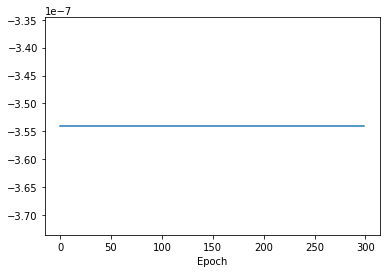

In [91]:
plt.figure()
plt.plot(log_means)
# plt.plot(losses)
# plt.plot(p_values)
plt.xlabel('Epoch')
plt.show()

<tf.Tensor: id=1879, shape=(), dtype=float32, numpy=2.8610233e-07>

In [ ]:
def train():
    
        action = agent(
            batch.frame
        )
        
        # distribution of portfolio 
        # in next step
        future_omega = 0
        
        w_t = future_omega[:batch.size-1]
        w_t1 = action[1:batch.size]
        mu = 1 - (tf.reduce_sum(
            tf.abs(w_t1[:, 1:]-w_t[:, 1:]),
            axis=1
        )*batch.commission + batch.decay)
        
        
        free_rets = tf.reduce_sum(
            tf.concat(
                [
                    action*(batch.next_prices-batch.current_prices),
                    tf.ones([batch.size,1])
                ], 
                axis=1
            ), 
            axis=1
        )
        
        rets = free_rets * ( 
            tf.concat(
                [
                tf.ones(1),
                mu
                ],
                axis=0
            )
        )
        
        # Mean returns
        mean = tf.reduce_mean(rets)
        log_mean = tf.reduce_mean(tf.log(rets))
        log_mean_free = tf.reduce_mean(free_rets)
        
        # Standard Deviation of returns
        stdev = tf.sqrt(tf.reduce_mean(
           (rets - mean) ** 2
        ))
        
        # Sharpe ratio
        sharp_ratio = (mean - 1) / stdev
        
        # Portfolio value
        p_value = tf.reduce_prod(rets)
        
        loss = -tf.reduce_mean(tf.log(rets))
        
        tf.train.AdamOptimizer(learning_rate).minimize(
            loss, 
            global_step=self.__global_step
        )
        